In [1]:
#Generation of basis, jump operators and damping rates in latex format, as well as generation of NOESY spectra and FID

import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
import sys 
import json
#import pandas as pd

from basis_utils import read_spinach_info, build_list_ISTs, NormalizeBasis, build_symbolic_list_ISTs,Sz,Sx,Sy,Sz, InnProd
from analytical_fit import get_chemical_shifts, Get_Det_And_Rates ,Get_Det_And_Rates_latex,RelMat_from_ops_and_rates
from simulation_utils import GenNOESYSpectrum, GenH0_Ham,  HamMatRep
import openfermion as of
from scipy.io import savemat

from matplotlib import pyplot as plt


In [2]:
def GenH0_Ham_allparam(freqs,Jcoups,Nspins):
    """
    Returns: the zeroth order Hamiltonian considered for dynamical evolution in nthe simulations, in OpenFermion format
    Args:
    freqs: frequencies, in Hz 
    Jcoups: matrix of size N x N, N being the number of spins, that encodes the scalar couplings between spins (in Hz)
    Nspins: number of spins in the system
    """

    #offset = -46681
    #B0 = 9.3933

    Hamiltonian = of.QubitOperator()

    for i in range(Nspins):
        
        Hamiltonian+=2*np.pi*freqs[i]*Sz(i)
        for j in range(i+1,Nspins):

            Hamiltonian+=2*np.pi*Jcoups[i,j]*(Sx(i)*Sx(j)+Sy(i)*Sy(j)+Sz(i)*Sz(j))
    
    return Hamiltonian



def Damp_rate_filt(list_ops,list_damp_rates,thresh=0.1, symb_rate_list = None):
    """
    Filter out the jump operator and damping rates based on a cutoff imposed on the damping rates, all channels below thresh are discarted
    """
    filt_ops = []
    filt_rates = []

    if symb_rate_list!=None:
        filt_symb_rates = []


    N = len(list_ops)
    for i in range(N):
        if np.abs(list_damp_rates[i])> thresh:
            filt_ops.append(list_ops[i])
            filt_rates.append(list_damp_rates[i])

        if symb_rate_list != None:
            filt_symb_rates.append(symb_rate_list[i])

    if symb_rate_list != None:
        return filt_ops,filt_rates, filt_symb_rates
    else:
        return filt_ops,filt_rates

def Rotating_filt(list_jumps,list_damp_rates,list_dets,thresh=1e-6, symb_rate_list=None):

    non_rot_jumps = []
    non_rot_rates = []

    if symb_rate_list != None:
        non_rot_symb_rates =[]

    for i in range(len(list_jumps)):
        if np.abs(list_dets[i]) < thresh:
            non_rot_jumps.append(list_jumps[i])
            non_rot_rates.append(list_damp_rates[i])

            if symb_rate_list != None:
                non_rot_symb_rates.append(symb_rate_list[i])

    if symb_rate_list != None:
        return non_rot_jumps, non_rot_rates, non_rot_symb_rates
    else:
        return non_rot_jumps, non_rot_rates


def Filt_nonrot_and_small(list_jumps,list_damp_rates,list_dets,thresh_rot=1e-6,thresh_sm=0.1, symb_rate_list =None):

    #first, filter the "non-rotating" jump operators
    if symb_rate_list != None:
        filt_ops, filt_rates, filt_symb_rates = Rotating_filt(list_jumps,list_damp_rates, list_dets, thresh_rot, symb_rate_list=symb_rate_list)
    else:
        filt_ops, filt_rates = Rotating_filt(list_jumps,list_damp_rates, list_dets, thresh_rot)

    #then filter acoording to the magnitude of the damping rates...
    if symb_rate_list != None:
        trunc_ops, trunc_rates, trunc_symb_rates = Damp_rate_filt(filt_ops,filt_rates, thresh_sm, symb_rate_list= filt_symb_rates)

        return trunc_ops, trunc_rates, trunc_symb_rates
    else:
        trunc_ops, trunc_rates = Damp_rate_filt(filt_ops,filt_rates, thresh_sm)

        return trunc_ops, trunc_rates



In [3]:
#Functions to construct and format text in latex format...
import math
import re

def round_up(number, decimals=0):
    factor = 10 ** decimals
    return math.ceil(number * factor) / factor


def Gen_diss_param_latex_table(list_jumps,list_symb_rates,list_damp_rates,mol_str,ndecs=2):
    """
    Generation of a latex table that uses the longtable environment 
    Args:
    list_jumps, list of jump operators in latex format
    list_symb_rates, list of symbolic rates in latex format
    list_damp_rates, list fo damping rates
    mol_str, a string to identify the molecule
    """

    Nentries = len(list_jumps)
    lines = []
    lines.append(r'\begin{longtable}{|c|c|c|}')
    lines.append('\\caption{Jump operators and their associated damping rates for'+mol_str+'} \\\\')
    lines.append('\hline')
    lines.append(r'\textbf{$L_j$} & \textbf{$\kappa_j$} & \textbf{Value (Hz)} \\')
    lines.append(r'\hline')
    lines.append(r'\endhead')

    for i in range(Nentries):
        line = '$'+list_jumps[i]+'$'+' & '+'$'+list_symb_rates[i]+'$'+ ' & '+str(round_up(list_damp_rates[i],ndecs))+'\\\\\\hline'
        lines.append(line)
        #list_jumps

    lines.append(r'\end{longtable}')
    text_to_save = "\n".join(lines)

    return text_to_save


def basis_to_latex_format(arr):
    latex_list = []
    
    # Regex to capture 'S', an optional superscript (+, -, or z), and a digit index.
    pattern = r"S([+-z]?)(\d)"
    
    for entry in arr:
        # Find all matches of S terms in each entry
        matches = re.findall(pattern, entry)
        
        # Convert each match to the LaTeX format
        latex_terms = []
        for superscript, index in matches:
            if superscript == "z":
                latex_term = f"S_{{{index}z}}"
            elif superscript == "+":
                latex_term = f"S_{{{index}+}}"
            elif superscript == "-":
                latex_term = f"S_{{{index}-}}"
            else:
                latex_term = f"S_{{{index}}}"
            latex_terms.append(latex_term)
        
        # Join terms with spaces and wrap in $ for LaTeX format
        latex_str = "$" + " ".join(latex_terms) + "$"
        latex_list.append(latex_str)
    
    return latex_list


def formattedlist_to_latextable(latex_list,mol_str):
    """
    Generation of a latex table that uses the longtable environment 

    """

    Nbasis = len(latex_list)
    lines = []

    lines.append(r'\begin{longtable}{|c|c|}')
    lines.append(r'\caption{Basis operators for '+mol_str+' } \\')
    lines.append(r'\hline')
    lines.append(r'\textbf{Operator} & \textbf{Index}\\')
    lines.append(r'\hline')
    lines.append(r'\endhead')

    for i in range(Nbasis):
        line = latex_list[i]+' & '+str(i)+' \\\\\\hline'
        lines.append(line)

    lines.append(r'\end{longtable}')

    text_to_save = "\n".join(lines)

    return text_to_save


def basis_to_latextable(arr,mol_str):
    latex_list = basis_to_latex_format(arr)
    
    return formattedlist_to_latextable(latex_list,mol_str)



def filter_jumps(list_jumps,list_symb_rates,list_damp_rates,list_dets,thresh):
    filt_jump_ops = []
    filt_damp_rates = []
    filt_symb_rates = []
    #thresh = 370
    for i in range(len(list_dets)):
        if np.abs(list_dets[i])<thresh:
            filt_jump_ops.append(list_jumps[i])
            filt_symb_rates.append(list_symb_rates[i])
            filt_damp_rates.append(list_damp_rates[i])

    return filt_jump_ops, filt_symb_rates, filt_damp_rates

def SaveNOESYData(tmix,t_grid1,t_grid2,rho0,Ham,R,FID,path):
    """
    path corresponds to the path where the data is saved... 
    """
    data = {
    "constants": {
        "tmix": tmix
    },
    "vectors": {
    "t_grid1": np.array(np.real(t_grid1)).tolist(),
    "t_grid2": np.array(np.real(t_grid2)).tolist(),
    "rho0": np.array(np.real(rho0)).tolist(),
    },
    "matrices": {
        "Ham":np.array(np.real(Ham)).tolist(),
        "R": np.array(np.real(R)).tolist(),
        "FID_real":np.array(np.real(FID)).tolist(),
        "FID_imag": np.array(np.imag(FID)).tolist()
    }
    }

    # Save to JSON file
    with open(path, "w") as f:
        json.dump(data, f, indent=4)




# DFG case

In [6]:
#translation of basis format in Spinach to symbolic form
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""

data = read_spinach_info(text)

basis = build_list_ISTs(data)
prefacts,Symb_basis = build_symbolic_list_ISTs(data)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis = NormalizeBasis(basis,n_qubits=2,checkOrth=True)
#Normbasis = np.array(Normbasis)

In [7]:
InnProd(Normbasis[1],Normbasis[1])

(0.9999999999999998+0j)

In [53]:
#For completeness, calculation of the coherent part of the Hamiltonian...
offset = -46681
B0 = 9.3933
zeeman_scalar_1 = -113.8796
zeeman_scalar_2 = -129.8002
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2]
Jcoup = 238.0633
Jcoups = np.zeros([2,2])
Jcoups[0,1] = Jcoup
gammaF = 251814800


#GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaF)

#freqs = [-2996.74,2996.74] # we were missing a factor of 2!
freqs = [0.0,2*2996.74]
#freqs = [-11968.88/(2*np.pi),6860.19/(2*np.pi)]

H0_Ham_dfg = GenH0_Ham_allparam(freqs,Jcoups,2)

#zeeman_scalars = [0.0,-15.920]
zeeman_scalars = [0.0, -15.920599]
offset=0.0

H0_dfg_ref = GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaF)


#H0_dfg_frame =  HamMatRep(H0_Ham_dfg,Normbasis,n_qubits=2)

#H0_dfg_frame =  HamMatRep(H0_Ham_dfg,Normbasis)
H0_dfg_frame =  HamMatRep(H0_dfg_ref,Normbasis)


savemat('H0_dfg_frame.mat', {'H0_dfg': H0_dfg_frame})

loadMat = spio.loadmat('../matlab_analysis/DFG_secular.mat',squeeze_me=True)

Ham = loadMat['p']['H'].item()



In [54]:
H0_dfg_ref

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
373.9489571846715 [Z0 Z1] +
18829.069237188673 [Z1]

In [51]:
H0_dfg_ref

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
373.9489571846715 [Z0 Z1] +
18828.3608082864 [Z1]

In [47]:
2996.7*2*np.pi

18828.821410025066

In [52]:
np.linalg.norm(Ham-H0_dfg_frame)

8.615408772583885e-07

In [22]:
6860.190*2/(2*np.pi)

2183.6662980991787

In [25]:
-243.6798*gammaF*B0/1e6

-576393.366343099

In [35]:
H0_dfg_ref

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
373.9489571846715 [Z0 Z1] +
18829.05859301485 [Z1]

In [33]:
H0_dfg_ref

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
373.9489571846715 [Z0 Z1] +
-18829.05859301485 [Z1]

In [29]:
1e6*2*(11968.88028+6860.19013)/(251814800*B0)

15.920599991650654

In [15]:
11968.8802863+6860.1901334

18829.0704197

In [18]:
H0_Ham_dfg 

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-9414.536368718676 [Z0] +
373.9489571846715 [Z0 Z1] +
9414.536368718676 [Z1]

In [76]:
loadMat = spio.loadmat('./data/DFG.mat',squeeze_me=True)

Ham = loadMat['p']['H'].item()


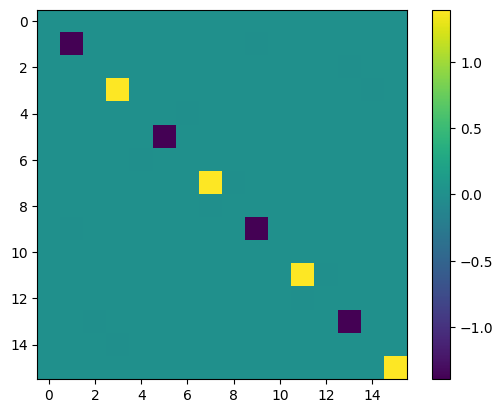

In [40]:
plt.imshow(np.real(Ham-H0_dfg_frame), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

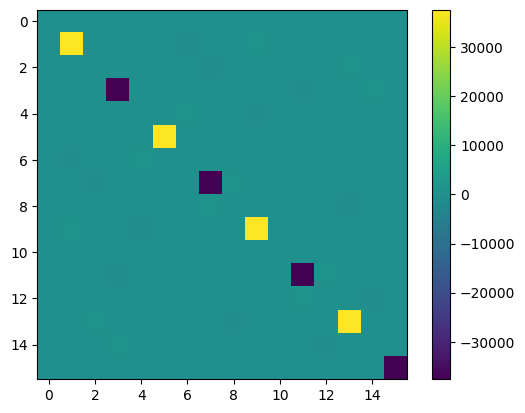

In [39]:
plt.imshow(np.real(H0_dfg_frame), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [88]:
np.linalg.norm(Ham-4*H0_dfg_frame)

6.28069997787362e-07

In [80]:
H0_dfg_ref

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-11968.88028638772 [Z0] +
373.9489571846715 [Z0 Z1] +
6860.190133486933 [Z1]

In [69]:
6860.190+11968.88

18829.07

In [18]:
#parameters of the model for determination of jump operators and their associated damping rates...

gammaF = 251814800
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10

coords = np.array([coord1,coord2])

w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])
tc = 0.5255e-9
B0 = 9.3933

zeeman_scalar_1 = -113.8796
zeeman_scalar_2 = -129.8002
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2]

#w0*zeeman_scalars[i]/1e6
chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)
Nspins = 2

list_jumps, list_symb_rates, list_damp_rates, list_dets = Get_Det_And_Rates_latex(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)
list_jumps_old, list_damp_rates_old, list_dets_old = Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)
list_damp_rates_old = np.array(list_damp_rates_old)/4.0
#generate relxation matrix and save in MATLAB format...
thresh=1e-6

non_rot_jumps = []
non_rot_rates = []
for i in range(len(list_jumps_old)):
    if np.abs(list_dets_old[i]) < thresh:
        non_rot_jumps.append(list_jumps_old[i])
        non_rot_rates.append(list_damp_rates_old[i])



filt_jumps,filt_rates = Damp_rate_filt(non_rot_jumps,non_rot_rates, thresh=1.0)

R_approx_damp1 = RelMat_from_ops_and_rates(filt_jumps,filt_rates,Normbasis,Nspins)


#R_sec = RelMat_from_ops_and_rates(list_jumps_old,list_damp_rates_old,Normbasis,Nspins)

In [24]:
chem_shifts[1]-chem_shifts[0]

37658.14083974931

In [25]:
(-376417768.6316+376411775.1523)*2*np.pi

-37658.141076784006

In [164]:
trunc_jumps, trunc_rates, trunc_symb_rates = Filt_nonrot_and_small(list_jumps,list_damp_rates,list_dets,thresh_rot=1e-6,thresh_sm=1.0,symb_rate_list=list_symb_rates)

text_dfg_diss = Gen_diss_param_latex_table(trunc_jumps,trunc_symb_rates,trunc_rates,'DFG',ndecs=3)



In [166]:
with open("./data/maxtrunc_jumps_dfg.txt", "w") as file:
    file.write(text_dfg_diss)

In [128]:
#savemat('R_dfg_app1.mat', {'R_1_app': 4*R_approx_damp1})

In [130]:
###Bug in the calculation of relaxation out of operators and list of rates


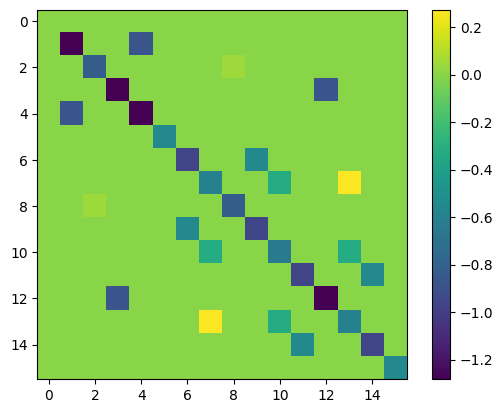

In [114]:
plt.imshow(np.real(4*R_sec), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [120]:
list_jumps_old, list_damp_rates_old

([['S0+S1+', 'S0-S1-'],
  ['S0-S1-', 'S0+S1+'],
  ['S0zS1+', 'S0zS1-'],
  ['S0zS1-', 'S0zS1+'],
  ['S0+S1z', 'S0zS1-'],
  ['S0zS1-', 'S0+S1z'],
  ['S0+S1z', 'S0-S1z'],
  ['S0-S1z', 'S0+S1z'],
  ['S0zS1+', 'S0-S1z'],
  ['S0-S1z', 'S0zS1+'],
  ['S0zS1z', 'S0zS1z'],
  ['S0+S1-', 'S0zS1z'],
  ['S0zS1z', 'S0+S1-'],
  ['S0zS1z', 'S0-S1+'],
  ['S0-S1+', 'S0zS1z'],
  ['S0+S1-', 'S0-S1+'],
  ['S0-S1+', 'S0+S1-'],
  ['S0-S1+', 'S0-S1+'],
  ['S0-S1+', 'S0-S1+']],
 array([ 0.11440129,  0.11440129,  0.32273715,  0.32273715,  0.32273715,
         0.32273715,  0.32273091,  0.32273091,  0.32273091,  0.32273091,
         2.19001282, -0.54750321, -0.54750321, -0.5475032 , -0.5475032 ,
         0.1368758 ,  0.1368758 ,  0.1368758 ,  0.1368758 ]))

In [17]:
1/(2*np.pi)

0.15915494309189535

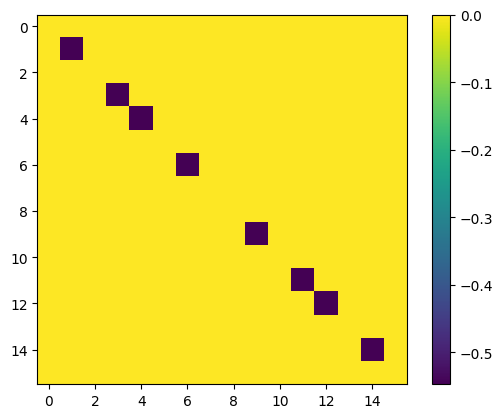

In [115]:
plt.imshow(np.real(4*R_approx_damp1), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [103]:

chem_shifts[0]-chem_shifts[1]

-37658.14083974931

In [94]:
len(list_jumps), len(list_symb_rates), len(list_damp_rates), len(list_dets)

(20, 20, 20, 20)

In [16]:
#filter jump operators and rates...
filt_jumps,filt_symb_rates,filt_rates = filter_jumps(list_jumps,list_symb_rates,list_damp_rates,list_dets,thresh=1e-6)


text_dfg_diss = Gen_diss_param_latex_table(filt_jumps,filt_symb_rates,filt_rates,'DFG',ndecs=3)

text_dfg_basis = basis_to_latextable(Symb_basis,'DFG')

In [18]:
###saving in text files...
with open("./data/jumps_dfg.txt", "w") as file:
    file.write(text_dfg_diss)

with open("./data/basis_dfg.txt", "w") as file:
    file.write(text_dfg_basis)

In [55]:
#Generation and saving of NOESY data...
loadMat = spio.loadmat('./data/DFG.mat',squeeze_me=True)
AuxMats = spio.loadmat('./data/DFG_NOESYmatrices.mat',squeeze_me=True)

###These are the parameters generated by Spinach
Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item() # We can substitute this by any approximation to the relaxation matrix
t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

###Dynamical evolution for calculation of 2D spectra...
##TODO: we can simply modify the script to incorporate 1) retrieval of synthesized circuits,
#and 2) the already-developed circuit simulator

Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)

Dim = Ham.shape[0]

rho0 = np.array(AuxMats['rho0'].toarray())
rho0 = rho0.flatten()
coil = AuxMats['coil']


tmix = 0.5
dt1 = 1.1561e-04
dt2 = 1.1561e-04

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 1024

##Definition of pulses in the experiment...
#This also depends on the definition of the basis....
Lx = AuxMats['Lx'].toarray()
Ly = AuxMats['Ly'].toarray()

#Spectrum, FID = GenNOESYSpectrum(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)


In [30]:
#Save noesy data as a JSON file
SaveNOESYData(tmix,t_grid1,t_grid2,rho0,Ham,R,FID,'./data/DFG_NOESY_dat.json')

# The Alanine case

In [29]:
text4="""1      (0,0)   (0,0)   (0,0)   (0,0)   
  2      (0,0)   (0,0)   (0,0)   (1,1)   
  3      (0,0)   (0,0)   (0,0)   (1,0)   
  4      (0,0)   (0,0)   (0,0)   (1,-1)  
  5      (0,0)   (0,0)   (1,1)   (0,0)   
  6      (0,0)   (0,0)   (1,1)   (1,1)   
  7      (0,0)   (0,0)   (1,1)   (1,0)   
  8      (0,0)   (0,0)   (1,1)   (1,-1)  
  9      (0,0)   (0,0)   (1,0)   (0,0)   
  10     (0,0)   (0,0)   (1,0)   (1,1)   
  11     (0,0)   (0,0)   (1,0)   (1,0)   
  12     (0,0)   (0,0)   (1,0)   (1,-1)  
  13     (0,0)   (0,0)   (1,-1)  (0,0)   
  14     (0,0)   (0,0)   (1,-1)  (1,1)   
  15     (0,0)   (0,0)   (1,-1)  (1,0)   
  16     (0,0)   (0,0)   (1,-1)  (1,-1)  
  17     (0,0)   (1,1)   (0,0)   (0,0)   
  18     (0,0)   (1,1)   (0,0)   (1,1)   
  19     (0,0)   (1,1)   (0,0)   (1,0)   
  20     (0,0)   (1,1)   (0,0)   (1,-1)  
  21     (0,0)   (1,1)   (1,1)   (0,0)   
  22     (0,0)   (1,1)   (1,1)   (1,1)   
  23     (0,0)   (1,1)   (1,1)   (1,0)   
  24     (0,0)   (1,1)   (1,1)   (1,-1)  
  25     (0,0)   (1,1)   (1,0)   (0,0)   
  26     (0,0)   (1,1)   (1,0)   (1,1)   
  27     (0,0)   (1,1)   (1,0)   (1,0)   
  28     (0,0)   (1,1)   (1,0)   (1,-1)  
  29     (0,0)   (1,1)   (1,-1)  (0,0)   
  30     (0,0)   (1,1)   (1,-1)  (1,1)   
  31     (0,0)   (1,1)   (1,-1)  (1,0)   
  32     (0,0)   (1,1)   (1,-1)  (1,-1)  
  33     (0,0)   (1,0)   (0,0)   (0,0)   
  34     (0,0)   (1,0)   (0,0)   (1,1)   
  35     (0,0)   (1,0)   (0,0)   (1,0)   
  36     (0,0)   (1,0)   (0,0)   (1,-1)  
  37     (0,0)   (1,0)   (1,1)   (0,0)   
  38     (0,0)   (1,0)   (1,1)   (1,1)   
  39     (0,0)   (1,0)   (1,1)   (1,0)   
  40     (0,0)   (1,0)   (1,1)   (1,-1)  
  41     (0,0)   (1,0)   (1,0)   (0,0)   
  42     (0,0)   (1,0)   (1,0)   (1,1)   
  43     (0,0)   (1,0)   (1,0)   (1,0)   
  44     (0,0)   (1,0)   (1,0)   (1,-1)  
  45     (0,0)   (1,0)   (1,-1)  (0,0)   
  46     (0,0)   (1,0)   (1,-1)  (1,1)   
  47     (0,0)   (1,0)   (1,-1)  (1,0)   
  48     (0,0)   (1,0)   (1,-1)  (1,-1)  
  49     (0,0)   (1,-1)  (0,0)   (0,0)   
  50     (0,0)   (1,-1)  (0,0)   (1,1)   
  51     (0,0)   (1,-1)  (0,0)   (1,0)   
  52     (0,0)   (1,-1)  (0,0)   (1,-1)  
  53     (0,0)   (1,-1)  (1,1)   (0,0)   
  54     (0,0)   (1,-1)  (1,1)   (1,1)   
  55     (0,0)   (1,-1)  (1,1)   (1,0)   
  56     (0,0)   (1,-1)  (1,1)   (1,-1)  
  57     (0,0)   (1,-1)  (1,0)   (0,0)   
  58     (0,0)   (1,-1)  (1,0)   (1,1)   
  59     (0,0)   (1,-1)  (1,0)   (1,0)   
  60     (0,0)   (1,-1)  (1,0)   (1,-1)  
  61     (0,0)   (1,-1)  (1,-1)  (0,0)   
  62     (0,0)   (1,-1)  (1,-1)  (1,1)   
  63     (0,0)   (1,-1)  (1,-1)  (1,0)   
  64     (0,0)   (1,-1)  (1,-1)  (1,-1)  
  65     (1,1)   (0,0)   (0,0)   (0,0)   
  66     (1,1)   (0,0)   (0,0)   (1,1)   
  67     (1,1)   (0,0)   (0,0)   (1,0)   
  68     (1,1)   (0,0)   (0,0)   (1,-1)  
  69     (1,1)   (0,0)   (1,1)   (0,0)   
  70     (1,1)   (0,0)   (1,1)   (1,1)   
  71     (1,1)   (0,0)   (1,1)   (1,0)   
  72     (1,1)   (0,0)   (1,1)   (1,-1)  
  73     (1,1)   (0,0)   (1,0)   (0,0)   
  74     (1,1)   (0,0)   (1,0)   (1,1)   
  75     (1,1)   (0,0)   (1,0)   (1,0)   
  76     (1,1)   (0,0)   (1,0)   (1,-1)  
  77     (1,1)   (0,0)   (1,-1)  (0,0)   
  78     (1,1)   (0,0)   (1,-1)  (1,1)   
  79     (1,1)   (0,0)   (1,-1)  (1,0)   
  80     (1,1)   (0,0)   (1,-1)  (1,-1)  
  81     (1,1)   (1,1)   (0,0)   (0,0)   
  82     (1,1)   (1,1)   (0,0)   (1,1)   
  83     (1,1)   (1,1)   (0,0)   (1,0)   
  84     (1,1)   (1,1)   (0,0)   (1,-1)  
  85     (1,1)   (1,1)   (1,1)   (0,0)   
  86     (1,1)   (1,1)   (1,1)   (1,1)   
  87     (1,1)   (1,1)   (1,1)   (1,0)   
  88     (1,1)   (1,1)   (1,1)   (1,-1)  
  89     (1,1)   (1,1)   (1,0)   (0,0)   
  90     (1,1)   (1,1)   (1,0)   (1,1)   
  91     (1,1)   (1,1)   (1,0)   (1,0)   
  92     (1,1)   (1,1)   (1,0)   (1,-1)  
  93     (1,1)   (1,1)   (1,-1)  (0,0)   
  94     (1,1)   (1,1)   (1,-1)  (1,1)   
  95     (1,1)   (1,1)   (1,-1)  (1,0)   
  96     (1,1)   (1,1)   (1,-1)  (1,-1)  
  97     (1,1)   (1,0)   (0,0)   (0,0)   
  98     (1,1)   (1,0)   (0,0)   (1,1)   
  99     (1,1)   (1,0)   (0,0)   (1,0)   
  100    (1,1)   (1,0)   (0,0)   (1,-1)  
  101    (1,1)   (1,0)   (1,1)   (0,0)   
  102    (1,1)   (1,0)   (1,1)   (1,1)   
  103    (1,1)   (1,0)   (1,1)   (1,0)   
  104    (1,1)   (1,0)   (1,1)   (1,-1)  
  105    (1,1)   (1,0)   (1,0)   (0,0)   
  106    (1,1)   (1,0)   (1,0)   (1,1)   
  107    (1,1)   (1,0)   (1,0)   (1,0)   
  108    (1,1)   (1,0)   (1,0)   (1,-1)  
  109    (1,1)   (1,0)   (1,-1)  (0,0)   
  110    (1,1)   (1,0)   (1,-1)  (1,1)   
  111    (1,1)   (1,0)   (1,-1)  (1,0)   
  112    (1,1)   (1,0)   (1,-1)  (1,-1)  
  113    (1,1)   (1,-1)  (0,0)   (0,0)   
  114    (1,1)   (1,-1)  (0,0)   (1,1)   
  115    (1,1)   (1,-1)  (0,0)   (1,0)   
  116    (1,1)   (1,-1)  (0,0)   (1,-1)  
  117    (1,1)   (1,-1)  (1,1)   (0,0)   
  118    (1,1)   (1,-1)  (1,1)   (1,1)   
  119    (1,1)   (1,-1)  (1,1)   (1,0)   
  120    (1,1)   (1,-1)  (1,1)   (1,-1)  
  121    (1,1)   (1,-1)  (1,0)   (0,0)   
  122    (1,1)   (1,-1)  (1,0)   (1,1)   
  123    (1,1)   (1,-1)  (1,0)   (1,0)   
  124    (1,1)   (1,-1)  (1,0)   (1,-1)  
  125    (1,1)   (1,-1)  (1,-1)  (0,0)   
  126    (1,1)   (1,-1)  (1,-1)  (1,1)   
  127    (1,1)   (1,-1)  (1,-1)  (1,0)   
  128    (1,1)   (1,-1)  (1,-1)  (1,-1)  
  129    (1,0)   (0,0)   (0,0)   (0,0)   
  130    (1,0)   (0,0)   (0,0)   (1,1)   
  131    (1,0)   (0,0)   (0,0)   (1,0)   
  132    (1,0)   (0,0)   (0,0)   (1,-1)  
  133    (1,0)   (0,0)   (1,1)   (0,0)   
  134    (1,0)   (0,0)   (1,1)   (1,1)   
  135    (1,0)   (0,0)   (1,1)   (1,0)   
  136    (1,0)   (0,0)   (1,1)   (1,-1)  
  137    (1,0)   (0,0)   (1,0)   (0,0)   
  138    (1,0)   (0,0)   (1,0)   (1,1)   
  139    (1,0)   (0,0)   (1,0)   (1,0)   
  140    (1,0)   (0,0)   (1,0)   (1,-1)  
  141    (1,0)   (0,0)   (1,-1)  (0,0)   
  142    (1,0)   (0,0)   (1,-1)  (1,1)   
  143    (1,0)   (0,0)   (1,-1)  (1,0)   
  144    (1,0)   (0,0)   (1,-1)  (1,-1)  
  145    (1,0)   (1,1)   (0,0)   (0,0)   
  146    (1,0)   (1,1)   (0,0)   (1,1)   
  147    (1,0)   (1,1)   (0,0)   (1,0)   
  148    (1,0)   (1,1)   (0,0)   (1,-1)  
  149    (1,0)   (1,1)   (1,1)   (0,0)   
  150    (1,0)   (1,1)   (1,1)   (1,1)   
  151    (1,0)   (1,1)   (1,1)   (1,0)   
  152    (1,0)   (1,1)   (1,1)   (1,-1)  
  153    (1,0)   (1,1)   (1,0)   (0,0)   
  154    (1,0)   (1,1)   (1,0)   (1,1)   
  155    (1,0)   (1,1)   (1,0)   (1,0)   
  156    (1,0)   (1,1)   (1,0)   (1,-1)  
  157    (1,0)   (1,1)   (1,-1)  (0,0)   
  158    (1,0)   (1,1)   (1,-1)  (1,1)   
  159    (1,0)   (1,1)   (1,-1)  (1,0)   
  160    (1,0)   (1,1)   (1,-1)  (1,-1)  
  161    (1,0)   (1,0)   (0,0)   (0,0)   
  162    (1,0)   (1,0)   (0,0)   (1,1)   
  163    (1,0)   (1,0)   (0,0)   (1,0)   
  164    (1,0)   (1,0)   (0,0)   (1,-1)  
  165    (1,0)   (1,0)   (1,1)   (0,0)   
  166    (1,0)   (1,0)   (1,1)   (1,1)   
  167    (1,0)   (1,0)   (1,1)   (1,0)   
  168    (1,0)   (1,0)   (1,1)   (1,-1)  
  169    (1,0)   (1,0)   (1,0)   (0,0)   
  170    (1,0)   (1,0)   (1,0)   (1,1)   
  171    (1,0)   (1,0)   (1,0)   (1,0)   
  172    (1,0)   (1,0)   (1,0)   (1,-1)  
  173    (1,0)   (1,0)   (1,-1)  (0,0)   
  174    (1,0)   (1,0)   (1,-1)  (1,1)   
  175    (1,0)   (1,0)   (1,-1)  (1,0)   
  176    (1,0)   (1,0)   (1,-1)  (1,-1)  
  177    (1,0)   (1,-1)  (0,0)   (0,0)   
  178    (1,0)   (1,-1)  (0,0)   (1,1)   
  179    (1,0)   (1,-1)  (0,0)   (1,0)   
  180    (1,0)   (1,-1)  (0,0)   (1,-1)  
  181    (1,0)   (1,-1)  (1,1)   (0,0)   
  182    (1,0)   (1,-1)  (1,1)   (1,1)   
  183    (1,0)   (1,-1)  (1,1)   (1,0)   
  184    (1,0)   (1,-1)  (1,1)   (1,-1)  
  185    (1,0)   (1,-1)  (1,0)   (0,0)   
  186    (1,0)   (1,-1)  (1,0)   (1,1)   
  187    (1,0)   (1,-1)  (1,0)   (1,0)   
  188    (1,0)   (1,-1)  (1,0)   (1,-1)  
  189    (1,0)   (1,-1)  (1,-1)  (0,0)   
  190    (1,0)   (1,-1)  (1,-1)  (1,1)   
  191    (1,0)   (1,-1)  (1,-1)  (1,0)   
  192    (1,0)   (1,-1)  (1,-1)  (1,-1)  
  193    (1,-1)  (0,0)   (0,0)   (0,0)   
  194    (1,-1)  (0,0)   (0,0)   (1,1)   
  195    (1,-1)  (0,0)   (0,0)   (1,0)   
  196    (1,-1)  (0,0)   (0,0)   (1,-1)  
  197    (1,-1)  (0,0)   (1,1)   (0,0)   
  198    (1,-1)  (0,0)   (1,1)   (1,1)   
  199    (1,-1)  (0,0)   (1,1)   (1,0)   
  200    (1,-1)  (0,0)   (1,1)   (1,-1)  
  201    (1,-1)  (0,0)   (1,0)   (0,0)   
  202    (1,-1)  (0,0)   (1,0)   (1,1)   
  203    (1,-1)  (0,0)   (1,0)   (1,0)   
  204    (1,-1)  (0,0)   (1,0)   (1,-1)  
  205    (1,-1)  (0,0)   (1,-1)  (0,0)   
  206    (1,-1)  (0,0)   (1,-1)  (1,1)   
  207    (1,-1)  (0,0)   (1,-1)  (1,0)   
  208    (1,-1)  (0,0)   (1,-1)  (1,-1)  
  209    (1,-1)  (1,1)   (0,0)   (0,0)   
  210    (1,-1)  (1,1)   (0,0)   (1,1)   
  211    (1,-1)  (1,1)   (0,0)   (1,0)   
  212    (1,-1)  (1,1)   (0,0)   (1,-1)  
  213    (1,-1)  (1,1)   (1,1)   (0,0)   
  214    (1,-1)  (1,1)   (1,1)   (1,1)   
  215    (1,-1)  (1,1)   (1,1)   (1,0)   
  216    (1,-1)  (1,1)   (1,1)   (1,-1)  
  217    (1,-1)  (1,1)   (1,0)   (0,0)   
  218    (1,-1)  (1,1)   (1,0)   (1,1)   
  219    (1,-1)  (1,1)   (1,0)   (1,0)   
  220    (1,-1)  (1,1)   (1,0)   (1,-1)  
  221    (1,-1)  (1,1)   (1,-1)  (0,0)   
  222    (1,-1)  (1,1)   (1,-1)  (1,1)   
  223    (1,-1)  (1,1)   (1,-1)  (1,0)   
  224    (1,-1)  (1,1)   (1,-1)  (1,-1)  
  225    (1,-1)  (1,0)   (0,0)   (0,0)   
  226    (1,-1)  (1,0)   (0,0)   (1,1)   
  227    (1,-1)  (1,0)   (0,0)   (1,0)   
  228    (1,-1)  (1,0)   (0,0)   (1,-1)  
  229    (1,-1)  (1,0)   (1,1)   (0,0)   
  230    (1,-1)  (1,0)   (1,1)   (1,1)   
  231    (1,-1)  (1,0)   (1,1)   (1,0)   
  232    (1,-1)  (1,0)   (1,1)   (1,-1)  
  233    (1,-1)  (1,0)   (1,0)   (0,0)   
  234    (1,-1)  (1,0)   (1,0)   (1,1)   
  235    (1,-1)  (1,0)   (1,0)   (1,0)   
  236    (1,-1)  (1,0)   (1,0)   (1,-1)  
  237    (1,-1)  (1,0)   (1,-1)  (0,0)   
  238    (1,-1)  (1,0)   (1,-1)  (1,1)   
  239    (1,-1)  (1,0)   (1,-1)  (1,0)   
  240    (1,-1)  (1,0)   (1,-1)  (1,-1)  
  241    (1,-1)  (1,-1)  (0,0)   (0,0)   
  242    (1,-1)  (1,-1)  (0,0)   (1,1)   
  243    (1,-1)  (1,-1)  (0,0)   (1,0)   
  244    (1,-1)  (1,-1)  (0,0)   (1,-1)  
  245    (1,-1)  (1,-1)  (1,1)   (0,0)   
  246    (1,-1)  (1,-1)  (1,1)   (1,1)   
  247    (1,-1)  (1,-1)  (1,1)   (1,0)   
  248    (1,-1)  (1,-1)  (1,1)   (1,-1)  
  249    (1,-1)  (1,-1)  (1,0)   (0,0)   
  250    (1,-1)  (1,-1)  (1,0)   (1,1)   
  251    (1,-1)  (1,-1)  (1,0)   (1,0)   
  252    (1,-1)  (1,-1)  (1,0)   (1,-1)  
  253    (1,-1)  (1,-1)  (1,-1)  (0,0)   
  254    (1,-1)  (1,-1)  (1,-1)  (1,1)   
  255    (1,-1)  (1,-1)  (1,-1)  (1,0)   
  256    (1,-1)  (1,-1)  (1,-1)  (1,-1)"""



In [30]:
data_ala = read_spinach_info(text4)

basis_ala = build_list_ISTs(data_ala)
prefacts,Symb_ALA_basis = build_symbolic_list_ISTs(data_ala)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_ala = NormalizeBasis(basis_ala,n_qubits=4,checkOrth=False)
Normbasis_ala = np.array(Normbasis_ala)

In [31]:
tc = 0.05e-9 # in seconds
gammaH = 2.6752e8
B0 =14.1
Nspins = 4

w1 = -600344544.5579
w2 = -600343524.536
w3 = -600343524.536
w4 = -600343524.536

freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [ 0.6861,0.2705,1.5010],
    [1.3077, 1.1298, -1.3993],
    [0.7905, 2.2125, -0.0860],
    [ 2.3693, 1.3798, 0.0233]
])

coords = coords*1e-10

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
zeeman_scalar_1 = 3.4938
zeeman_scalar_2 = 1.7947
zeeman_scalar_3 = 1.7947
zeeman_scalar_4 = 1.7947

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaH,B0,zeeman_scalars)

list_jumps, list_symb_rates, list_damp_rates, list_dets = Get_Det_And_Rates_latex(2*np.pi*freqs,tc,coords,Nspins,gammaH,chem_shifts)

In [32]:
trunc_jumps, trunc_rates, trunc_symb_rates = Filt_nonrot_and_small(list_jumps,list_damp_rates,list_dets,thresh_rot=1e-6,thresh_sm=0.5,symb_rate_list=list_symb_rates)

text_ala_diss = Gen_diss_param_latex_table(trunc_jumps,trunc_symb_rates,trunc_rates,'Alanine',ndecs=3)



In [43]:
offset = 1500
B0 = 14.1
zeeman_scalar_1 = 3.4938
zeeman_scalar_2 = 1.7947
zeeman_scalar_3 = 1.7947
zeeman_scalar_4 = 1.7947
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]


#Jcoup = 238.0633

Jcoups = np.zeros([4,4])
#First, in Hz...
Jcoups[0,1] = 3.82
Jcoups[0,2] = 3.82
Jcoups[0,3] = 3.82
Jcoups[1,2] = -7.0
Jcoups[1,3] = -7.0
Jcoups[2,3] = -7.0

gammaH = 2.6752e8

freqs = np.array([-510.02,0.0,0.0,0.0])
Nspins = 4


H0_ala = GenH0_Ham_allparam(freqs,Jcoups,Nspins)
#H0_ala = GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaH)

H0_ala_frame =  HamMatRep(H0_ala,Normbasis_ala,n_qubits=4)





In [53]:
510*np.pi

1602.2122533307945

In [49]:
H0_ala

6.000441968356505 [X0 X1] +
6.000441968356505 [X0 X2] +
6.000441968356505 [X0 X3] +
6.000441968356505 [Y0 Y1] +
6.000441968356505 [Y0 Y2] +
6.000441968356505 [Y0 Y3] +
-1602.2750851838662 [Z0] +
6.000441968356505 [Z0 Z1] +
6.000441968356505 [Z0 Z2] +
6.000441968356505 [Z0 Z3] +
-10.995574287564276 [X1 X2] +
-10.995574287564276 [X1 X3] +
-10.995574287564276 [Y1 Y2] +
-10.995574287564276 [Y1 Y3] +
-10.995574287564276 [Z1 Z2] +
-10.995574287564276 [Z1 Z3] +
-10.995574287564276 [X2 X3] +
-10.995574287564276 [Y2 Y3] +
-10.995574287564276 [Z2 Z3]

In [48]:
savemat('H0_ala_frame.mat', {'H0_ala': H0_ala_frame})

In [46]:
import pickle


Dict ={'H0_frame': H0_ala_frame}
with open('./H0_frameALA.pk', 'wb') as handle:
    pickle.dump(H0_ala_frame, handle)

In [34]:
(1327.556+1876.973720)/(2*np.pi)

510.0167452228873

In [171]:
with open("./data/jumps_ala_truncdamp_05.txt", "w") as file:
    file.write(text_ala_diss)a

In [58]:
####Exploring cutoffs in damping rates for spectra calculation...
from analytical_fit import Get_Det_And_Rates, RelMat_from_ops_and_rates

def Damp_rate_filt(list_ops,list_damp_rates,thresh=0.1):
    """
    Filter out the jump operator and damping rates based on a cutoff imposed on the damping rates, all channels below thresh are discarted
    """
    filt_ops = []
    filt_rates = []
    N = len(list_ops)
    for i in range(N):
        if np.abs(list_damp_rates[i])> thresh:
            filt_ops.append(list_ops[i])
            filt_rates.append(list_damp_rates[i])
    
    return filt_ops,filt_rates


list_jumps_old, list_damp_rates_old, list_dets_old = Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaH,chem_shifts)
#the actual damping rates are one-fourth of the ones calculated above
list_damp_rates_old = np.array(list_damp_rates_old)/4.0

filt_jumps,filt_rates = Damp_rate_filt(list_jumps_old,list_damp_rates_old)

#R_ala_trunc = RelMat_from_ops_and_rates(filt_jumps,filt_rates,Normbasis_ala,Nspins)



In [17]:

filt_jumps,filt_symb_rates,filt_rates = filter_jumps(list_jumps,list_symb_rates,list_damp_rates,list_dets,thresh=1e-6)


text_ala_diss = Gen_diss_param_latex_table(filt_jumps,filt_symb_rates,filt_rates,'Alanine',ndecs=3)

text_ala_basis = basis_to_latextable(Symb_ALA_basis,'Alanine')

In [18]:
for i in range(len(list_jumps)):
    if list_jumps[i] == 'J_{+}\\left(S_{1z}S_{3z},S_{1z}S_{3z}\\right)':
        #print("True")
        print(i)

570


In [19]:
for i in range(len(filt_jumps)):
    if filt_jumps[i] == 'J_{+}\\left(S_{1z}S_{2z},S_{1z}S_{2z}\\right)':
        #print("True")
        print(i)

190


In [21]:
filt_jumps[190], filt_rates[190]

('J_{+}\\left(S_{1z}S_{2z},S_{1z}S_{2z}\\right)', 0.7189938337589143)

In [22]:
###saving in text files...
with open("./data/jumps_ala.txt", "w") as file:
    file.write(text_ala_diss)

with open("./data/basis_ala.txt", "w") as file:
    file.write(text_ala_basis)

In [35]:
loadMat = spio.loadmat('./data/NOESYdata_ALA_withGradients.mat',squeeze_me=True)

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

R_ala = loadMat['p']['R'].item()
H_ala = loadMat['p']['H'].item().toarray()

rho0 = np.array(loadMat['p']['rho0'].item().toarray())

coil = np.array(loadMat['p']['coil'].item())

Lx = loadMat['p']['Lx'].item().toarray() 
Ly = loadMat['p']['Ly'].item().toarray() 

###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)

#Parameters taken from Spinach script
tmix = 1.0
dt1 = 0.25e-3
dt2 = 0.25e-3

##Parameters for Fourier transform
zerofill1 = 4096
zerofill2 = 4096


#Spectrum, FID = GenNOESYSpectrum(H_ala,R_ala,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)


In [91]:
###loading and comparing with approximate relaxation matrices...
#and saving them in MATLAB format...
from scipy.io import savemat
import pickle
from matplotlib import pyplot as plt
f = open('./data/ALA_Rapprox_dampTrunc_0.1.pk','rb')

dat=pickle.load(f)
R_01_app = dat['AddMat']
savemat('R_ala_app01.mat', {'R_01_app': R_01_app})

f = open('./data/ALA_Rapprox_dampTrunc_0.5.pk','rb')
dat=pickle.load(f)
R_05_app = dat['AddMat']
savemat('R_ala_app05.mat',{'R_05_app':R_05_app})



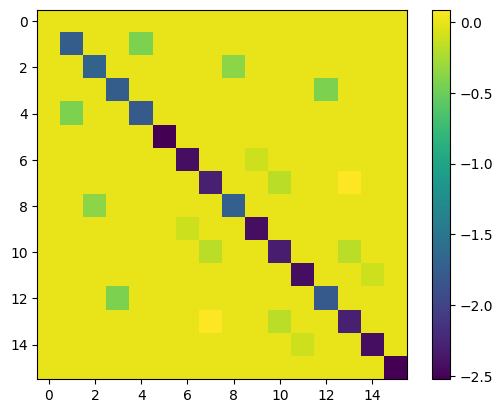

In [45]:
plt.imshow(np.real(R_ala.toarray()[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [47]:
np.linalg.norm(R_ala.toarray()-R_01_app)

6.8697273119432465

In [48]:
np.linalg.norm(R_ala.toarray())

34.19978962028727

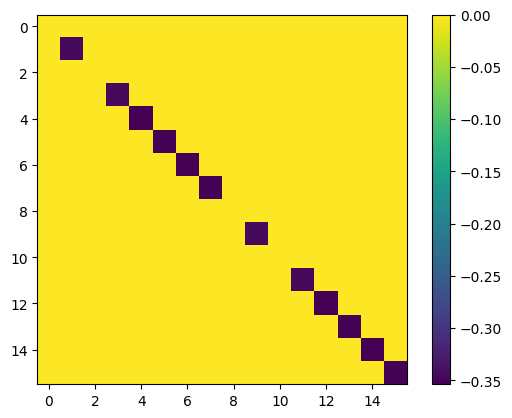

In [55]:
plt.imshow(np.real(R_05_app[0:16,0:16]), cmap='viridis', interpolation='nearest')
# Add a color bar to sh-1j*ow the scale
plt.colorbar()

In [69]:
R_01_app[15,15]

(-2.2861709964861108+0j)

In [88]:
####To verify the correctness of the approximate relaxation matrices, we explicitly calculate some matrix entries...
from analytical_fit import convert_operator_string
from basis_utils import Linb_Channel, InnProd
from openfermion import hermitian_conjugated


list_jumps_old, list_damp_rates_old, list_dets_old = Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaH,chem_shifts)
#the actual damping rates are one-fourth of the ones calculated above
list_damp_rates_old = np.array(list_damp_rates_old)/4

filt_jumps,filt_rates = Damp_rate_filt(list_jumps_old,list_damp_rates_old,thresh=0.5)

targ_bas_idxs=[9,9]
mat_el = 0.0 
#######
for i in range(len(filt_rates)):
        JOp1 = convert_operator_string(filt_jumps[i][0])
        JOp2 = hermitian_conjugated(convert_operator_string(filt_jumps[i][1]))

        Rel_chan = Linb_Channel(JOp1,JOp2,Normbasis_ala[targ_bas_idxs[1]],gamma=filt_rates[i])
        in_prod=InnProd(Normbasis_ala[targ_bas_idxs[0]],Rel_chan,n_qubits=4)
        mat_el+=in_prod+np.conjugate(in_prod)

       



In [87]:
mat_el, R_05_app[targ_bas_idxs[0],targ_bas_idxs[1]]

((-0.3539147595910376+0j), (-0.3539147595910376+0j))

In [90]:
filt_jumps

[['S1zS2z', 'S1zS2z'], ['S1zS3z', 'S1zS3z'], ['S2zS3z', 'S2zS3z']]

[['S0zS2z', 'S1zS2z'],
 ['S0zS3z', 'S1zS3z'],
 ['S1zS2z', 'S0zS2z'],
 ['S1+S2+', 'S1-S2-'],
 ['S1-S2-', 'S1+S2+'],
 ['S1zS2+', 'S1zS2-'],
 ['S1zS2-', 'S1zS2+'],
 ['S1+S2z', 'S1zS2-'],
 ['S1zS2-', 'S1+S2z'],
 ['S1+S2z', 'S1-S2z'],
 ['S1-S2z', 'S1+S2z'],
 ['S1zS2+', 'S1-S2z'],
 ['S1-S2z', 'S1zS2+'],
 ['S1zS2z', 'S1zS2z'],
 ['S1+S2-', 'S1zS2z'],
 ['S1zS2z', 'S1+S2-'],
 ['S1zS2z', 'S1-S2+'],
 ['S1-S2+', 'S1zS2z'],
 ['S1zS3z', 'S0zS3z'],
 ['S1+S3+', 'S1-S3-'],
 ['S1-S3-', 'S1+S3+'],
 ['S1zS3+', 'S1zS3-'],
 ['S1zS3-', 'S1zS3+'],
 ['S1+S3z', 'S1zS3-'],
 ['S1zS3-', 'S1+S3z'],
 ['S1+S3z', 'S1-S3z'],
 ['S1-S3z', 'S1+S3z'],
 ['S1zS3+', 'S1-S3z'],
 ['S1-S3z', 'S1zS3+'],
 ['S1zS3z', 'S1zS3z'],
 ['S1+S3-', 'S1zS3z'],
 ['S1zS3z', 'S1+S3-'],
 ['S1zS3z', 'S1-S3+'],
 ['S1-S3+', 'S1zS3z'],
 ['S2+S3+', 'S2-S3-'],
 ['S2-S3-', 'S2+S3+'],
 ['S2zS3+', 'S2zS3-'],
 ['S2zS3-', 'S2zS3+'],
 ['S2+S3z', 'S2zS3-'],
 ['S2zS3-', 'S2+S3z'],
 ['S2+S3z', 'S2-S3z'],
 ['S2-S3z', 'S2+S3z'],
 ['S2zS3+', 'S2-S3z'],
 ['S2-S3z',

In [63]:
len(filt_jumps), len(filt_rates)

(49, 49)

In [41]:



#Save noesy data as a JSON file
SaveNOESYData(tmix,t_grid1,t_grid2,rho0,H_ala,R_ala.toarray(),FID,'./data/ALA_NOESY_dat.json')

# The TFG case

In [14]:
data_tfg = read_spinach_info(text4)

basis_tfg = build_list_ISTs(data_tfg)
prefacts,Symb_TFG_basis = build_symbolic_list_ISTs(data_tfg)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis_tfg = NormalizeBasis(basis_tfg,n_qubits=4,checkOrth=False)
Normbasis_tfg = np.array(Normbasis_tfg)

In [15]:
tc = 0.951e-9 # in seconds
gammaF = 251814800
B0 =9.3933

w1 = -376415149.7831
w2 = -376410090.0768
w3 = -376411850.9715
w4 = -376411792.9965


freqs = np.array([w1,w2,w3,w4])

coords = np.array([
    [-0.0551 , -1.2087, -1.6523],
    [-0.8604, -2.3200, -0.0624],
    [-2.4464, -0.1125, -0.9776],
    [-1.9914, -0.0836, 1.0743]
])

coords = coords*1e-10

Nspins = 4

#R_kiteALA_dev = Kite_relMat(2*np.pi*freqs,tc,coords,Nspins,gammaH,Sub_norm_basis)
#R_kite_dev = KiteRelMatrixManyParallel(2*np.pi*freqs,tc,coords,Nspins,gammaH,Normbasis_ala,num_workers=20)

#isotropic chemical shifts in ppm taken from the chemical shift tensors introduced in Spinach
#-120.8361 -134.2763 -129.5988 -129.7528
zeeman_scalar_1 = -120.8361
zeeman_scalar_2 = -134.2763
zeeman_scalar_3 = -129.5988
zeeman_scalar_4 = -129.7528

zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

chem_shifts = get_chemical_shifts(gammaF,B0,zeeman_scalars)

#list_jumps, list_damp_rates, list_dets=Get_Det_And_Rates(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)


list_jumps, list_symb_rates, list_damp_rates, list_dets = Get_Det_And_Rates_latex(2*np.pi*freqs,tc,coords,Nspins,gammaF,chem_shifts)

In [16]:
offset = -49000
B0 = 9.3933
zeeman_scalar_1 = -120.8361
zeeman_scalar_2 = -134.2763
zeeman_scalar_3 = -129.5988
zeeman_scalar_4 = -129.7528
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2,zeeman_scalar_3,zeeman_scalar_4]

#Jcoup = 238.0633
Jcoups = np.zeros([4,4])
#Jcoups[0,1] = Jcoup
gammaF= 251814800

GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaH)

-2113.7870536310656 [Z0] +
14773.122775450553 [Z1] +
8896.088153530553 [Z2] +
9089.58111596253 [Z3]

In [175]:
trunc_jumps, trunc_rates, trunc_symb_rates = Filt_nonrot_and_small(list_jumps,list_damp_rates,list_dets,thresh_rot=370,thresh_sm=1.0,symb_rate_list=list_symb_rates)

text_tfg_diss = Gen_diss_param_latex_table(trunc_jumps,trunc_symb_rates,trunc_rates,'TFG',ndecs=3)


In [44]:
#filt_jumps,filt_symb_rates,filt_rates = filter_jumps(list_jumps,list_symb_rates,list_damp_rates,list_dets,thresh=370)


#text_tfg_diss = Gen_diss_param_latex_table(filt_jumps,filt_symb_rates,filt_rates,'TFG',ndecs=3)

text_tfg_basis = basis_to_latextable(Symb_basis,'TFG')

In [177]:
###saving in text files...
with open("./data/jumps_tfg_damptrunc1.txt", "w") as file:
    file.write(text_tfg_diss)

#with open("./data/basis_tfg.txt", "w") as file:
#    file.write(text_tfg_basis)

In [46]:
loadMat = spio.loadmat('./data/TFG_secular.mat',squeeze_me=True)

t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()
R_tfg = loadMat['p']['R'].item()
H_tfg = loadMat['p']['H'].item()

rho0 = np.array(loadMat['p']['rho0'].item().toarray())

coil = np.array(loadMat['p']['coil'].item())

Lx = loadMat['p']['Lx'].item().toarray() 
Ly = loadMat['p']['Ly'].item().toarray() 

###Dynamical evolution for calculation of 2D spectra...
Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)



#Parameters taken from Spinach script
tmix = 0.5
dt1 = 0.125e-3
dt2 = 0.125e-3

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 512


#Calculation of the NOESY spectra using the reference relaxation matrix and the Kite and the jump-operator-truncated approach

Ref_spec, FID = GenNOESYSpectrum(H_tfg,R_tfg,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

In [49]:
SaveNOESYData(tmix,t_grid1,t_grid2,rho0,H_tfg.toarray(),R_tfg,FID,'./data/TFG_NOESY_dat.json')

In [138]:
###loading and saving an approximation to relaxation matrix with large damping rate cutoff...
f =open('./data/R_TFG_Approx_damp_thresh1.pk','rb')
dat = pickle.load(f)

R_tfg_app = dat['KiteMat']

savemat('R_tfg_app1.mat',{'R_1_app':R_tfg_app})

In [137]:
R_tfg_app.shape

(256, 256)